# Hypothesis and proposed solution

**Hypothesis**: Neural network loss landscapes possess "gradient flat" regions where the gradient is approximately in the kernel of the Hessian. Applying Newton's method in this regime leads to bad steps (except isn't the multiplication with the inverse of the Hessian, not the Hessian itself?). Since algorithms like BFGS approximate Newton's method, perhaps they also can't handle gradient flat regions. This hypothesis as to why BFGS doesn't reach the architecture error could totally be wrong though, since the BFGS step isn't just a matrix multiplication, but rather a line search in a direction. But worth investigating.

**Solution**: Avoid second-order methods and try L4 and other techniques instead.

In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate, optimize

import torch
import torch.nn as nn
import torchvision

from precisionml.optimizers import ConjugateGradients, L4

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
torch.set_default_dtype(torch.float64)
device

'cuda:0'

### define losses

In [3]:
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss

## Let's first compare the magnitude of the gradient and the Hessian-gradient product at the beginning vs end of training

In [4]:
def hvp(model, v, loss_fn, x, y, r=1e-5):
    initial_params = [p.data.detach().clone() for p in model.parameters()]
    loss_fn(model(x), y).backward()
    initial_gradient = [p.grad.detach().clone() for p in model.parameters()]
    model.zero_grad()
    for i, param in enumerate(model.parameters()):
        param.data += r * v[i]
    loss_fn(model(x), y).backward()
    shifted_gradient = [p.grad.detach().clone() for p in model.parameters()]
    product = []
    for i in range(len(v)):
        diff_quotient = (shifted_gradient[i] - initial_gradient[i]) / r
        product.append(diff_quotient)
    model.zero_grad()
    for i, param in enumerate(model.parameters()):
        param.data = initial_params[i].clone()
    return product

def dot_prod(u, v):
    assert len(u) == len(v)
    result = 0
    for i in range(len(u)):
        result += torch.sum(u[i] * v[i])
    return result.item()

In [5]:
def loss(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    mlp.zero_grad()
    return np.concatenate(grads)

In [6]:
n = 200
x_line = y_line = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x_line, y_line)
Z = np.exp(X + Y)
x_2d = np.stack([X, Y], axis=2)
x = torch.from_numpy(x_2d.reshape((n*n, 2))).to(device)
y = torch.from_numpy(Z.reshape((n*n, 1))).to(device)

x_line = y_line = np.linspace(-1, 1, 257)
X, Y = np.meshgrid(x_line, y_line)
Z = np.exp(X + Y)
x_2d = np.stack([X, Y], axis=2)
x_test = torch.from_numpy(x_2d.reshape((257*257, 2))).to(device)
y_test = torch.from_numpy(Z.reshape((257*257, 1))).to(device)

In [7]:
width = 20
mlp = nn.Sequential(
    nn.Linear(2, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)
N = len(param_vector)

### initial values

In [8]:
rmse_loss_fn_torch(mlp(x), y).backward()
g0 = [p.grad.detach().clone() for p in mlp.parameters()]
print("|g|^2: {}".format(dot_prod(g0, g0)))
mlp.zero_grad()
Hv = hvp(mlp, g0, rmse_loss_fn_torch, x, y, r=1e-5)
print("|Hg|^2: {}".format(dot_prod(Hv, Hv)))

|g|^2: 1.9075417243024022
|Hg|^2: 3.244313016793226


In [29]:
result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x, y, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )


NameError: name 'x' is not defined

In [10]:
l = 0
for i, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[i]]
    l += lenghts[i]
    param_data_shaped = param_data.reshape(shapes[i])
    param.data = torch.tensor(param_data_shaped).to(device)

rmse_loss_fn_torch(mlp(x_test), y_test).item()

1.3894025260162552e-07

In [11]:
mlp.zero_grad()
rmse_loss_fn_torch(mlp(x), y).backward()
g0 = [p.grad.detach().clone() for p in mlp.parameters()]
print("|g|^2: {}".format(dot_prod(g0, g0)))
mlp.zero_grad()
Hv = hvp(mlp, g0, rmse_loss_fn_torch, x, y, r=1e-5)
print("|Hg|^2: {}".format(dot_prod(Hv, Hv)))

|g|^2: 0.0976853316126039
|Hg|^2: 441530621356.94604


In [12]:
print(rmse_loss_fn_torch(mlp(x), y))
mlp.zero_grad()

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


In [13]:
saved_params = [deepcopy(param.data.detach().clone()) for param in mlp.parameters()]

### examine curvature at BFGS endpoint

In [125]:
for i, param in enumerate(mlp.parameters()):
    param.data = saved_params[i].clone()
print(rmse_loss_fn_torch(mlp(x), y))
mlp.zero_grad()

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


In [114]:
convergence = []
v = [torch.randn(p.shape).to(device) for p in mlp.parameters()]
rs = [10**(-n) for n in range(2, 11)]
for r in rs:
    Hv = hvp(mlp, v, rmse_loss_fn_torch, x, y, r=r)
    vHv = dot_prod(v, Hv)
    vv = dot_prod(v, v)
    convergence.append(vHv / vv)

Text(0, 0.5, 'vHv / vv for a random, fixed v')

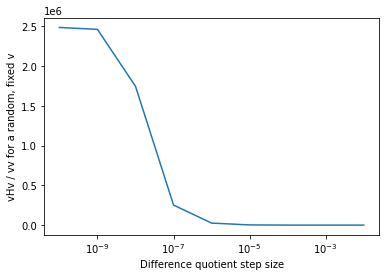

In [120]:
plt.plot(rs, convergence)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel("Difference quotient step size")
plt.ylabel("vHv / vv for a random, fixed v")

In [130]:
curvatures = []
for _ in tqdm(range(5000)):
    v = [torch.randn(p.shape).to(device) for p in mlp.parameters()]
    Hv = hvp(mlp, v, rmse_loss_fn_torch, x, y, r=1e-6)
    vHv = dot_prod(v, Hv)
    vv = dot_prod(v, v)
    curvatures.append(vHv / vv)

  0%|          | 0/5000 [00:00<?, ?it/s]

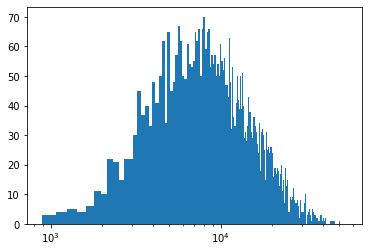

In [131]:
_ = plt.hist(curvatures, bins=300)
plt.xscale('log')

0it [00:00, ?it/s]

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

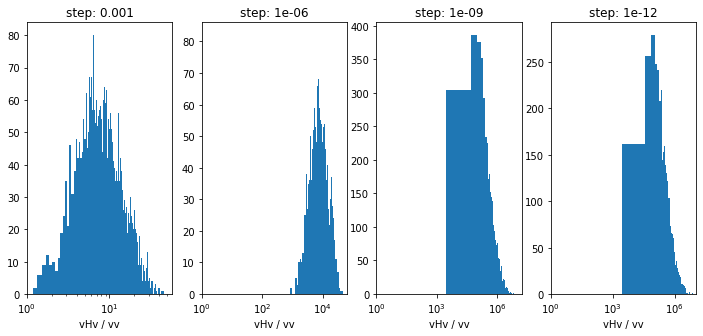

In [135]:
plt.figure(figsize=(12, 5))

rs = [1e-3, 1e-6, 1e-9, 1e-12]
for i, r in tqdm(enumerate(rs)):
    
    for j, param in enumerate(mlp.parameters()):
        param.data = saved_params[j].clone()
    print(rmse_loss_fn_torch(mlp(x), y))
    mlp.zero_grad()
    
    curvatures = []
    for _ in tqdm(range(5000), leave=False):
        v = [torch.randn(p.shape).to(device) for p in mlp.parameters()]
        Hv = hvp(mlp, v, rmse_loss_fn_torch, x, y, r=r)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures.append(vHv / vv)
    
    plt.subplot(1, len(rs), i+1)
    _ = plt.hist(curvatures, bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures))
    plt.title(f"step: {r}")
    plt.xlabel("vHv / vv")

### Plot histogram for various functions

In [156]:
n = 12

losses = []
curvatures = defaultdict(list)

for i in tqdm(range(n)):
    
    coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
    x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
    y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)
    
    x_i = torch.from_numpy(x_i).to(device)
    y_i = torch.from_numpy(y_i).to(device)
    
    width = 20
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )

    l = 0
    for j, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
    print(l)
    losses.append(l)
    mlp.zero_grad()
    
    for _ in tqdm(range(5000), leave=False):
        v = [torch.randn(p.shape).to(device) for p in mlp.parameters()]
        Hv = hvp(mlp, v, rmse_loss_fn_torch, x_i, y_i, r=1e-8)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures[i].append(vHv / vv)
    
    
    
    

  0%|          | 0/12 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 562
         Function evaluations: 683
         Gradient evaluations: 671
1.9424040912477354e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 684
         Function evaluations: 829
         Gradient evaluations: 817
2.521726973771276e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 687
         Function evaluations: 800
         Gradient evaluations: 788
3.120926299771742e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 529
         Function evaluations: 645
         Gradient evaluations: 633
1.257844660874587e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 645
         Function evaluations: 761
         Gradient evaluations: 749
1.334349525028941e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 910
         Function evaluations: 1068
         Gradient evaluations: 1056
6.545135454602271e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 611
         Function evaluations: 738
         Gradient evaluations: 726
1.9976785749136374e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 963
         Function evaluations: 1155
         Gradient evaluations: 1143
3.42036217700889e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 754
         Function evaluations: 874
         Gradient evaluations: 862
2.41945589990464e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 773
         Function evaluations: 922
         Gradient evaluations: 910
4.4572511971875413e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 715
         Function evaluations: 860
         Gradient evaluations: 848
2.5508999500770326e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 646
         Function evaluations: 762
         Gradient evaluations: 750
2.2248200947232632e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

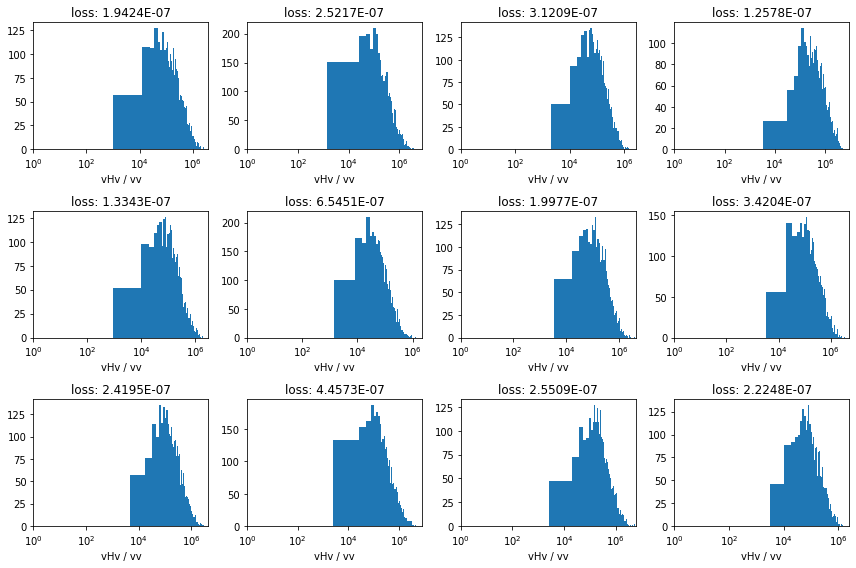

In [161]:
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.subplot(3, 4, i+1)
    
    _ = plt.hist(curvatures[i], bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures[i]))
    plt.title("loss: {:.4E}".format(losses[i]))
    plt.xlabel("vHv / vv")

plt.tight_layout()

### Let's see if we can use autograd's hvp for better numerical stability

In [201]:
width = 20
thing = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

In [202]:
p_tensors = tuple(p.data.detach().clone() for p in thing.parameters())
v = tuple(torch.randn(p.shape).to(device) for p in thing.parameters())

In [218]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

In [223]:
hvp(thing, v, rmse_loss_fn_torch, x_i, y_i, r=1e-7)[1]

tensor([-0.1191, -0.2454,  0.3004, -0.6634,  0.8248, -0.1275,  0.3975, -0.0760,
         0.8181,  0.0685, -0.2996, -0.2225,  0.0900,  0.3404, -0.2765,  0.5940,
        -0.5277,  0.0674, -0.3917,  0.2652], device='cuda:0')

In [224]:
hvp_autograd(thing, v, rmse_loss_fn_torch, x_i, y_i)[1]

tensor([-0.1191, -0.2454,  0.3004, -0.6634,  0.8248, -0.1275,  0.3975, -0.0760,
         0.8181,  0.0685, -0.2996, -0.2225,  0.0900,  0.3404, -0.2765,  0.5940,
        -0.5277,  0.0674, -0.3917,  0.2652], device='cuda:0')

In [229]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-18,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)

         Current function value: 0.000000
         Iterations: 1411
         Function evaluations: 1659
         Gradient evaluations: 1647
3.396698228654039e-07


In [232]:
convergence = []
v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
rs = [10**(-n) for n in range(2, 11)]
for r in rs:
    Hv = hvp(mlp, v, rmse_loss_fn_torch, x_i, y_i, r=r)
    vHv = dot_prod(v, Hv)
    vv = dot_prod(v, v)
    convergence.append(vHv / vv)

In [233]:
Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
vHv = dot_prod(v, Hv)
baseline = vHv / dot_prod(v, v)

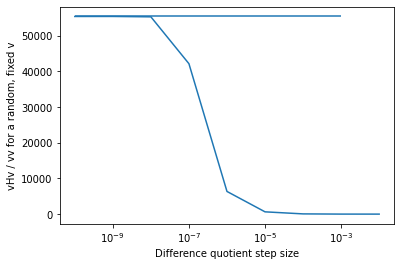

In [239]:
plt.plot(rs, convergence)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel("Difference quotient step size")
plt.ylabel("vHv / vv for a random, fixed v")
plt.hlines(baseline, 1e-10, 1e-3)

In [238]:
plt.hlines

<function matplotlib.pyplot.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)>

### Okay so actually our original finite difference method was pretty accurate when r was small enough.

### Let's see how the curvature looks at initialization vs after BFGS

In [242]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

# compute curvatures at initialization
initial_curvatures = []
for _ in tqdm(range(5000)):
    v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
    Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
    vHv = dot_prod(v, Hv)
    vv = dot_prod(v, v)
    initial_curvatures.append(vHv / vv)

result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-18,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)

# compute curvatures at end
final_curvatures = []
for _ in tqdm(range(5000)):
    v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
    Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
    vHv = dot_prod(v, Hv)
    vv = dot_prod(v, v)
    final_curvatures.append(vHv / vv)

  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 941
         Function evaluations: 1113
         Gradient evaluations: 1101
4.308528752625427e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Curvature at BFGS end')

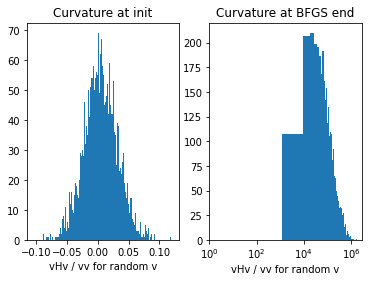

In [248]:
plt.subplot(1, 2, 1)
_ = plt.hist(initial_curvatures, bins=300)
plt.xlabel("vHv / vv for random v")
plt.title("Curvature at init")

plt.subplot(1, 2, 2)
_ = plt.hist(final_curvatures, bins=300)
plt.xscale('log')
plt.xlim(1, 1.1*np.max(final_curvatures))
plt.xlabel("vHv / vv for random v")
plt.title("Curvature at BFGS end")

### redo histogram ensemble with autograd hvp

In [251]:
n = 12

losses = []
curvatures = defaultdict(list)

for i in tqdm(range(n)):
    
    coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
    x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
    y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)
    
    x_i = torch.from_numpy(x_i).to(device)
    y_i = torch.from_numpy(y_i).to(device)
    
    width = 20
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )

    l = 0
    for j, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
    print(l)
    losses.append(l)
    mlp.zero_grad()
    
    for _ in tqdm(range(5000), leave=False):
        v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
        Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures[i].append(vHv / vv)
    

  0%|          | 0/12 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 396
         Function evaluations: 488
         Gradient evaluations: 476
1.051760829045072e-06


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 809
         Function evaluations: 948
         Gradient evaluations: 936
3.987020132091419e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 668
         Function evaluations: 793
         Gradient evaluations: 781
1.7496749730778545e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1066
         Function evaluations: 1249
         Gradient evaluations: 1237
2.0075018664152654e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1011
         Function evaluations: 1180
         Gradient evaluations: 1168
1.5935241035790693e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 775
         Function evaluations: 930
         Gradient evaluations: 918
1.7221375620078183e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1107
         Function evaluations: 1282
         Gradient evaluations: 1270
2.6321384954657816e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 832
         Function evaluations: 967
         Gradient evaluations: 955
9.299402957288845e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 758
         Function evaluations: 885
         Gradient evaluations: 873
1.8651446318557656e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 594
         Function evaluations: 707
         Gradient evaluations: 695
7.55195686385521e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 772
         Function evaluations: 915
         Gradient evaluations: 903
7.019083846216618e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 640
         Function evaluations: 782
         Gradient evaluations: 770
1.5063157736604494e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

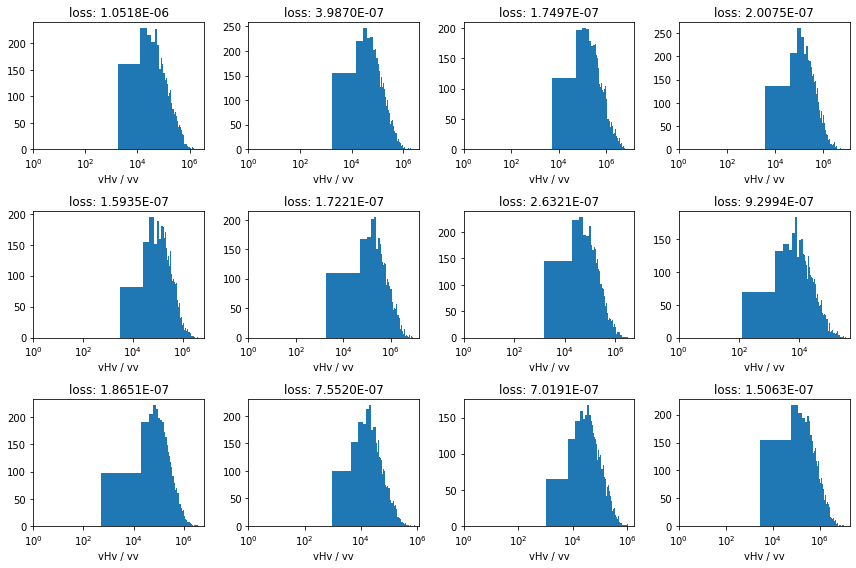

In [252]:
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.subplot(3, 4, i+1)
    
    _ = plt.hist(curvatures[i], bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures[i]))
    plt.title("loss: {:.4E}".format(losses[i]))
    plt.xlabel("vHv / vv")

plt.tight_layout()

### same but with sigmoid activations

In [253]:
n = 12

losses = []
curvatures = defaultdict(list)

for i in tqdm(range(n)):
    
    coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
    x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
    y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)
    
    x_i = torch.from_numpy(x_i).to(device)
    y_i = torch.from_numpy(y_i).to(device)
    
    width = 20
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Sigmoid(),
        nn.Linear(width, width),
        nn.Sigmoid(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )

    l = 0
    for j, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
    print(l)
    losses.append(l)
    mlp.zero_grad()
    
    for _ in tqdm(range(5000), leave=False):
        v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
        Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures[i].append(vHv / vv)
    

  0%|          | 0/12 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 1577
         Function evaluations: 1841
         Gradient evaluations: 1829
8.294781561556235e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 931
         Function evaluations: 1084
         Gradient evaluations: 1072
3.7481579295069014e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1420
         Function evaluations: 1680
         Gradient evaluations: 1668
2.0649109343722804e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 694
         Function evaluations: 818
         Gradient evaluations: 806
2.9340592695131363e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 964
         Function evaluations: 1125
         Gradient evaluations: 1113
8.291834059975975e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000002
         Iterations: 922
         Function evaluations: 1092
         Gradient evaluations: 1080
2.450815222549239e-06


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 583
         Function evaluations: 696
         Gradient evaluations: 684
5.939421124159126e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 584
         Function evaluations: 692
         Gradient evaluations: 680
4.130858244576288e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 538
         Function evaluations: 653
         Gradient evaluations: 641
5.31916713796474e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 1242
         Function evaluations: 1456
         Gradient evaluations: 1444
5.704947001496297e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 1000
         Function evaluations: 1131
         Gradient evaluations: 1119
8.037002153246846e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 826
         Function evaluations: 1001
         Gradient evaluations: 989
7.672340831074277e-07


  0%|          | 0/5000 [00:00<?, ?it/s]

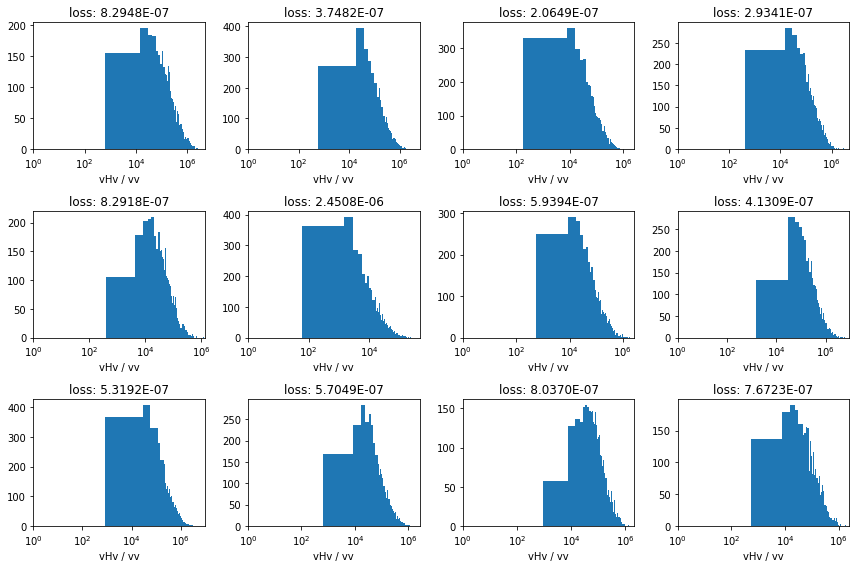

In [254]:
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.subplot(3, 4, i+1)
    
    _ = plt.hist(curvatures[i], bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures[i]))
    plt.title("loss: {:.4E}".format(losses[i]))
    plt.xlabel("vHv / vv")

plt.tight_layout()

### Let's try a different network width

In [255]:
n = 12

losses = []
curvatures = defaultdict(list)

for i in tqdm(range(n)):
    
    coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
    x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
    y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)
    
    x_i = torch.from_numpy(x_i).to(device)
    y_i = torch.from_numpy(y_i).to(device)
    
    width = 10
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )

    l = 0
    for j, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
    print(l)
    losses.append(l)
    mlp.zero_grad()
    
    for _ in tqdm(range(1000), leave=False):
        v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
        Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures[i].append(vHv / vv)
    

  0%|          | 0/12 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 849
         Function evaluations: 995
         Gradient evaluations: 983
1.4312182217831716e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 577
         Function evaluations: 679
         Gradient evaluations: 667
3.339647975011971e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 857
         Function evaluations: 1013
         Gradient evaluations: 1001
4.6835708703147126e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 578
         Function evaluations: 702
         Gradient evaluations: 690
2.549000434298225e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 564
         Function evaluations: 682
         Gradient evaluations: 670
5.010896825099174e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 771
         Function evaluations: 905
         Gradient evaluations: 893
8.81608306108174e-08


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1134
         Function evaluations: 1329
         Gradient evaluations: 1317
1.3908726140155053e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 940
         Function evaluations: 1103
         Gradient evaluations: 1091
4.5958402511330583e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 813
         Function evaluations: 955
         Gradient evaluations: 943
4.1995286947877593e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 1256
         Function evaluations: 1453
         Gradient evaluations: 1441
3.6428431018038725e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 790
         Function evaluations: 914
         Gradient evaluations: 902
1.3318809165741076e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 756
         Function evaluations: 906
         Gradient evaluations: 894
7.416190122375621e-07


  0%|          | 0/1000 [00:00<?, ?it/s]

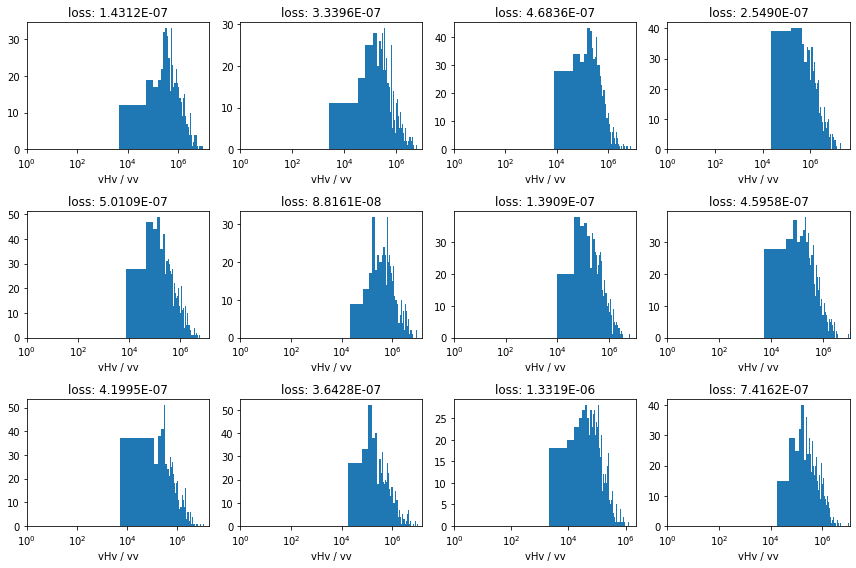

In [256]:
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.subplot(3, 4, i+1)
    
    _ = plt.hist(curvatures[i], bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures[i]))
    plt.title("loss: {:.4E}".format(losses[i]))
    plt.xlabel("vHv / vv")

plt.tight_layout()

(1e-09, 1e-05)

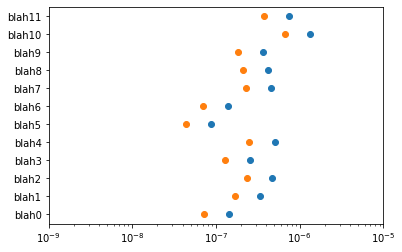

In [269]:
plt.plot(losses, ["blah"+str(i) for i in range(len(losses))], 'o')
plt.plot([l * 0.5 for l in losses], ["blah"+str(i) for i in range(len(losses))], 'o')
plt.xscale('log')
plt.xlim(1e-9, 1e-5)

In [270]:
import json

In [349]:
with open("../data/1/info.json", "r") as f:
    data = json.load(f)
with open("../data/1/config.json", "r") as f:
    config = json.load(f)

In [350]:
def key_to_tuple(key):
    width, depth, activation, trial = key.split('::')
    width = int(width)
    depth = int(depth)
    activation = activation.split('.')[-1][:-2]
    trial = int(trial)
    return (width, depth, activation, trial)

def tuple_to_desc(desc_tup):
    width, depth, activation, trial = desc_tup
    return f"w{width}d{depth}{activation}"

In [367]:
d = [(key_to_tuple(key), value) for key, value in data.items()]
# d.sort(key=lambda t: t[0][0] + 100*t[0][1], reverse=True)
d.sort(key=lambda t: t[0][2]+str(t[0][1]), reverse=True)
d = list(filter(lambda t: t[0][0] != 5, d))

Text(0.5, 0, 'RMSE loss')

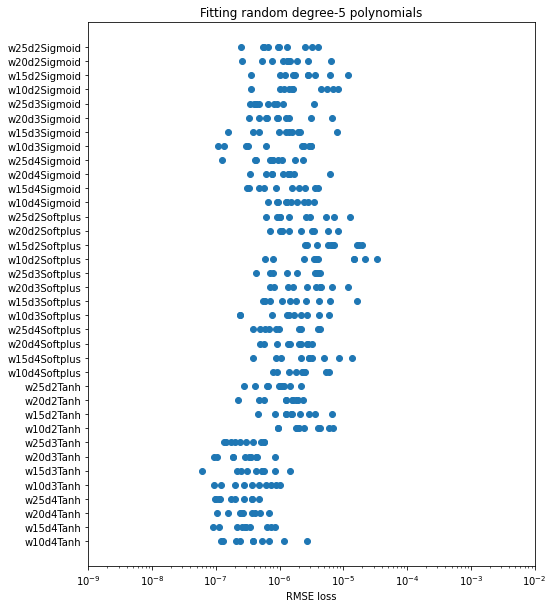

In [368]:
plt.figure(figsize=(8, 10))

descs = [tuple_to_desc(desc_tup) for desc_tup, v in d]
values = [v for desc_tup, v in d]
plt.plot(values, descs, 'o')
plt.xscale('log')
plt.xlim(1e-9, 1e-2)

plt.title("Fitting random degree-5 polynomials")
plt.xlabel("RMSE loss")

### Let's see if we can jump to the bottom with curvature-based GD step sizes after BFGS finishes

In [585]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [586]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [587]:

result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-18,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )


         Current function value: 0.000000
         Iterations: 732
         Function evaluations: 883
         Gradient evaluations: 871


In [588]:
l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

1.905550421036539e-07


In [589]:
saved_params = [deepcopy(param.data.detach().clone()) for param in mlp.parameters()]

### reset point

In [608]:
# revert to saved params
for i, param in enumerate(mlp.parameters()):
    param.data = saved_params[i].clone()
l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)

1.905550421036539e-07


In [609]:
losses = []
ggs = []
lrs = []
g_abs_means = []

prev_g = None
prev_d = None
for i in tqdm(range(2000)):
    mlp.zero_grad()
    l = rmse_loss_fn_torch(mlp(x_i), y_i)
    l.backward()
    g = tuple(p.grad.detach().clone() for p in mlp.parameters())
    if prev_g is None:
        d = tuple(-g_i for g_i in g)
    else:
        beta = dot_prod(g, g) / dot_prod(prev_g, prev_g)
        d = tuple(-g[i] + beta * prev_d[i] for i in range(len(g)))
    Hd = hvp_autograd(mlp, d, rmse_loss_fn_torch, x_i, y_i)
    dHd = dot_prod(d, Hd)
    gd = dot_prod(g, d)
    lr = - gd / dHd
    ggs.append(dot_prod(g, g))
    g_abs_mean = sum(torch.sum(torch.abs(g_i)) for g_i in g) / len(param_vector)
    g_abs_means.append(g_abs_mean)
    lrs.append(lr)
    with torch.no_grad():
        for j, p in enumerate(mlp.parameters()):
            p.add_(lr * d[j])
    prev_g = tuple(g_i.detach().clone() for g_i in g)
    prev_d = tuple(d_i.detach().clone() for d_i in d)
    losses.append(l.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'RMSE loss')

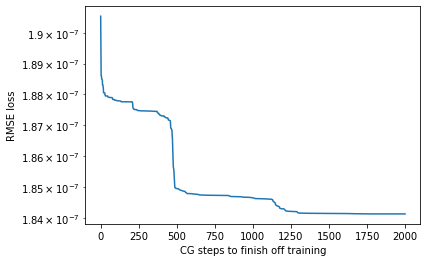

In [600]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel("CG steps to finish off training")
plt.ylabel('RMSE loss')

Text(0.5, 0, 'CG steps to finish off training')

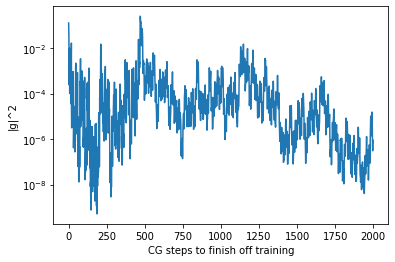

In [601]:
plt.plot(ggs)
plt.yscale('log')
plt.ylabel("|g|^2")
plt.xlabel("CG steps to finish off training")

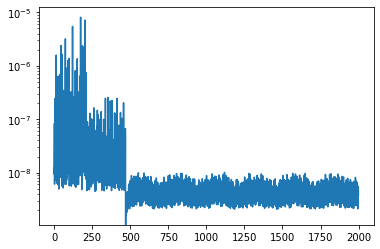

In [603]:
plt.plot(lrs)
plt.yscale('log')

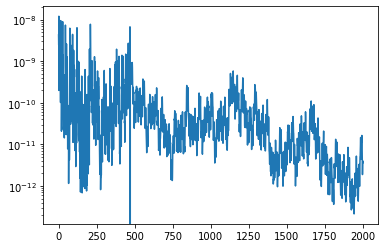

In [606]:
step_magnitudes = np.array(lrs) * np.sqrt(np.array(ggs))
plt.plot(step_magnitudes)
plt.yscale('log')

### same but for a teacher network target function

In [617]:
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
).to(device)

with torch.no_grad():
    y_i = teacher(x_i)

In [618]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [619]:

result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-18,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )


         Current function value: 0.000000
         Iterations: 359
         Function evaluations: 455
         Gradient evaluations: 443


In [620]:
l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

3.8369782809831305e-09


In [621]:
saved_params = [deepcopy(param.data.detach().clone()) for param in mlp.parameters()]

In [622]:
# revert to saved params
for i, param in enumerate(mlp.parameters()):
    param.data = saved_params[i].clone()
l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)

3.8369782809831305e-09


In [623]:
losses = []
ggs = []
lrs = []
g_abs_means = []

prev_g = None
prev_d = None
for i in tqdm(range(2000)):
    mlp.zero_grad()
    l = rmse_loss_fn_torch(mlp(x_i), y_i)
    l.backward()
    g = tuple(p.grad.detach().clone() for p in mlp.parameters())
    if prev_g is None:
        d = tuple(-g_i for g_i in g)
    else:
        beta = dot_prod(g, g) / dot_prod(prev_g, prev_g)
        d = tuple(-g[i] + beta * prev_d[i] for i in range(len(g)))
    Hd = hvp_autograd(mlp, d, rmse_loss_fn_torch, x_i, y_i)
    dHd = dot_prod(d, Hd)
    gd = dot_prod(g, d)
    lr = - gd / dHd
    ggs.append(dot_prod(g, g))
    g_abs_mean = sum(torch.sum(torch.abs(g_i)) for g_i in g) / len(param_vector)
    g_abs_means.append(g_abs_mean)
    lrs.append(lr)
    with torch.no_grad():
        for j, p in enumerate(mlp.parameters()):
            p.add_(lr * d[j])
    prev_g = tuple(g_i.detach().clone() for g_i in g)
    prev_d = tuple(d_i.detach().clone() for d_i in d)
    losses.append(l.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'RMSE loss')

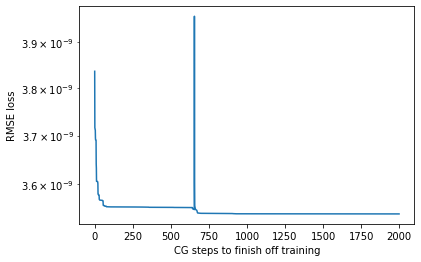

In [624]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel("CG steps to finish off training")
plt.ylabel('RMSE loss')

Text(0, 0.5, 'Step size magnitude (averaged across parameters)')

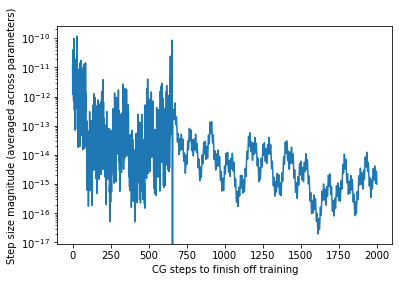

In [631]:
step_magnitudes = np.array(lrs) * np.array([x.item() for x in g_abs_means])
plt.plot(step_magnitudes)
plt.yscale('log')
plt.xlabel('CG steps to finish off training')
plt.ylabel("Step size magnitude (averaged across parameters)")

### It certainly appears like we are at a minima!

In [414]:
with open("../data/2/info.json", "r") as f:
    data = json.load(f)
with open("../data/2/config.json", "r") as f:
    config = json.load(f)

In [415]:
d = [(key_to_tuple(key), value) for key, value in data.items()]
# d.sort(key=lambda t: t[0][0] + 100*t[0][1], reverse=True)
d.sort(key=lambda t: t[0][2]+str(t[0][1]), reverse=True)
d = list(filter(lambda t: t[0][0] != 5, d))

Text(0.5, 0, 'RMSE loss')

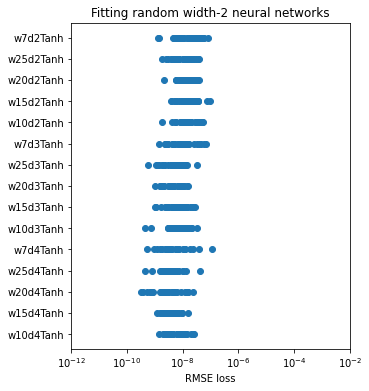

In [416]:
plt.figure(figsize=(5, 6))

descs = [tuple_to_desc(desc_tup) for desc_tup, v in d]
values = [v for desc_tup, v in d]
plt.plot(values, descs, 'o')
plt.xscale('log')
plt.xlim(1e-12, 1e-2)

plt.title("Fitting random width-2 neural networks")
plt.xlabel("RMSE loss")

In [432]:
with open("../data/3/info.json", "r") as f:
    data = json.load(f)
with open("../data/3/config.json", "r") as f:
    config = json.load(f)

In [433]:
d = [(key_to_tuple(key), value) for key, value in data.items()]
# d.sort(key=lambda t: t[0][0] + 100*t[0][1], reverse=True)
# d.sort(key=lambda t: t[0][2]+str(t[0][1]), reverse=True)
# d = list(filter(lambda t: t[0][0] != 5, d))

Text(0.5, 0, 'RMSE loss')

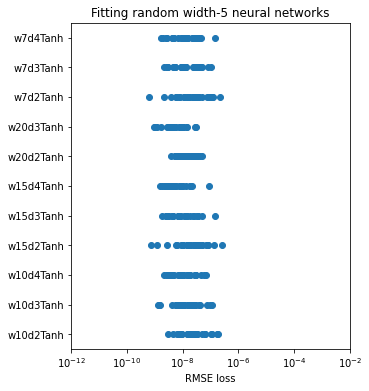

In [434]:
plt.figure(figsize=(5, 6))

descs = [tuple_to_desc(desc_tup) for desc_tup, v in d]
values = [v for desc_tup, v in d]
plt.plot(values, descs, 'o')
plt.xscale('log')
plt.xlim(1e-12, 1e-2)

plt.title("Fitting random width-5 neural networks")
plt.xlabel("RMSE loss")

### Let's try ensembling

In [468]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [469]:
mlps = []
param_vectors = []
for _ in range(5):
    width = 20
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)
    mlps.append(mlp)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    param_vectors.append(param_vector)

In [470]:
for i in tqdm(range(5)):
    
    result = optimize.minimize(loss,
                           param_vectors[i], 
                           args=(lenghts, shapes, mlps[i], rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
    #                                'finite_diff_rel_step': 1e-15
                           },
                        )
    l = 0
    for j, param in enumerate(mlps[i].parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlps[i](x_i), y_i).item()
    print(l)


  0%|          | 0/5 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 577
         Function evaluations: 696
         Gradient evaluations: 684
6.136283941339158e-07
         Current function value: 0.000001
         Iterations: 891
         Function evaluations: 1057
         Gradient evaluations: 1045
5.007149347962201e-07
         Current function value: 0.000000
         Iterations: 932
         Function evaluations: 1089
         Gradient evaluations: 1077
2.9135113859430497e-07
         Current function value: 0.000000
         Iterations: 653
         Function evaluations: 789
         Gradient evaluations: 777
3.466226847024812e-07
         Current function value: 0.000000
         Iterations: 808
         Function evaluations: 948
         Gradient evaluations: 936
3.65339417420333e-07


In [473]:
rmse_loss_fn_torch(sum([mlps[i](x_i) for i in range(5)]) / 5, y_i)

tensor(2.6756e-07, device='cuda:0', grad_fn=<SqrtBackward0>)

### Okay ensembling only gives a small improvement

### What about using a bigger network?

In [492]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [493]:
width = 40
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [494]:
import time

In [495]:
start_t = time.time()
result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
    #                                'finite_diff_rel_step': 1e-15
                           },
                        )
l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
end_t = time.time()

         Current function value: 0.000000
         Iterations: 510
         Function evaluations: 631
         Gradient evaluations: 619
4.215665663790319e-07


In [633]:
end_t - start_t

418.765100479126

In [497]:
n = 12

losses = []
curvatures = defaultdict(list)

for i in tqdm(range(n)):
    
    teacher = nn.Sequential(
        nn.Linear(1, 3),
        nn.Tanh(),
        nn.Linear(3, 3),
        nn.Tanh(),
        nn.Linear(3, 1)
    ).to(device)
    
    x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
    x_i = torch.from_numpy(x_i).to(device)
    with torch.no_grad():
        y_i = teacher(x_i)
    
    width = 20
    mlp = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    result = optimize.minimize(loss,
                           param_vector, 
                           args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                           jac=gradient,
                           method='BFGS',
                           options={
                               'disp': True,
                               'gtol': 1e-18,
                               'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                           },
                        )

    l = 0
    for j, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[j]]
        l += lenghts[j]
        param_data_shaped = param_data.reshape(shapes[j])
        param.data = torch.tensor(param_data_shaped).to(device)

    l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
    print(l)
    losses.append(l)
    mlp.zero_grad()
    
    for _ in tqdm(range(2000), leave=False):
        v = tuple(torch.randn(p.shape).to(device) for p in mlp.parameters())
        Hv = hvp_autograd(mlp, v, rmse_loss_fn_torch, x_i, y_i)
        vHv = dot_prod(v, Hv)
        vv = dot_prod(v, v)
        curvatures[i].append(vHv / vv)
    

  0%|          | 0/12 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 242
         Function evaluations: 331
         Gradient evaluations: 319
1.4669640389162774e-08


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 241
         Function evaluations: 332
         Gradient evaluations: 320
2.0996417659687244e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 341
         Function evaluations: 428
         Gradient evaluations: 416
4.4020536349598076e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 266
         Function evaluations: 356
         Gradient evaluations: 344
1.994567499509233e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 324
         Function evaluations: 422
         Gradient evaluations: 410
6.4744872289339006e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 235
         Function evaluations: 317
         Gradient evaluations: 305
2.3611081082668945e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 511
         Function evaluations: 638
         Gradient evaluations: 626
8.380940547006727e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 428
         Function evaluations: 540
         Gradient evaluations: 528
9.165287504966161e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 254
         Function evaluations: 356
         Gradient evaluations: 344
1.0229779801785465e-08


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 277
         Function evaluations: 363
         Gradient evaluations: 351
5.894833530201114e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 264
         Function evaluations: 348
         Gradient evaluations: 336
6.202413485191374e-10


  0%|          | 0/2000 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 196
         Function evaluations: 282
         Gradient evaluations: 270
4.26808823863977e-09


  0%|          | 0/2000 [00:00<?, ?it/s]

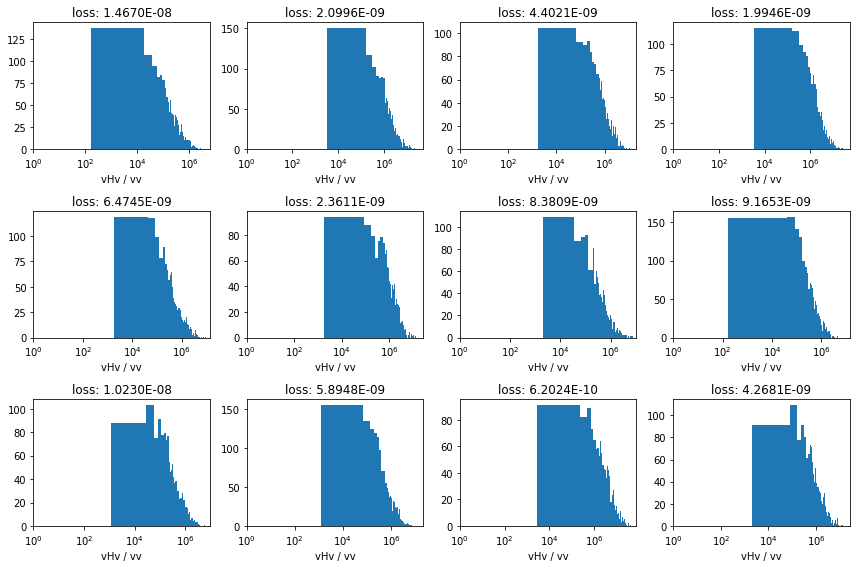

In [500]:
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.subplot(3, 4, i+1)
    
    _ = plt.hist(curvatures[i], bins=300)
    plt.xscale('log')
    plt.xlim(1, 1.1*np.max(curvatures[i]))
    plt.title("loss: {:.4E}".format(losses[i]))
    plt.xlabel("vHv / vv")

plt.tight_layout()

### is my method of sampling vectors v good? 

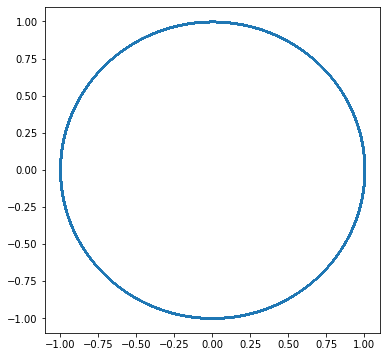

In [531]:
points = [np.random.randn(2,) for _ in range(100000)]
points = [p / np.sqrt(np.sum(np.power(p, 2))) for p in points]
plt.figure(figsize=(6, 6))
plt.scatter(*zip(*points), s=0.1)

In [532]:
angles = [np.arctan2(p[0], p[1]) for p in points]

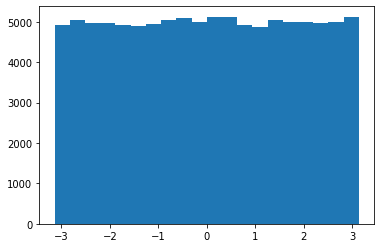

In [533]:
_ = plt.hist(angles, bins=20)

### yes, it appears that the angle of idd std normal vectors is uniformly distributed

### Let's try using a lower gtol value in BFGS

In [ ]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [ ]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

initial_params = [p.detach().clone() for p in mlp.parameters()]

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [21]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [22]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

initial_params = [p.detach().clone() for p in mlp.parameters()]

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [23]:
result = optimize.minimize(loss,
                               param_vector, 
                               args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
    #                                'finite_diff_rel_step': 1e-15
                               },
                            )

         Current function value: 0.000001
         Iterations: 682
         Function evaluations: 839
         Gradient evaluations: 827


In [24]:
l = 0
for i, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[i]]
    l += lenghts[i]
    param_data_shaped = param_data.reshape(shapes[i])
    param.data = torch.tensor(param_data_shaped).to(device)


rmse_loss_fn_torch(mlp(x_i), y_i).item()

1.2943121102771864e-06

In [25]:
for i, p in enumerate(mlp.parameters()):
    p.data = initial_params[i].clone()

In [26]:
params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [27]:
result = optimize.minimize(loss,
                               param_vector, 
                               args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-18,
                                   'maxiter': 25000,
    #                                'finite_diff_rel_step': 1e-15
                               },
                            )

         Current function value: 0.000001
         Iterations: 682
         Function evaluations: 839
         Gradient evaluations: 827


In [28]:
l = 0
for i, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[i]]
    l += lenghts[i]
    param_data_shaped = param_data.reshape(shapes[i])
    param.data = torch.tensor(param_data_shaped).to(device)


rmse_loss_fn_torch(mlp(x_i), y_i).item()

1.2943121102771864e-06

### reset point for tinkering with final stage of optimization

In [49]:
for i, param in enumerate(mlp.parameters()):
    param.data = saved_params[i].clone()

In [50]:
print(rmse_loss_fn_torch(mlp(x), y))
mlp.zero_grad()

tensor(1.4007e-07, device='cuda:0', grad_fn=<SqrtBackward0>)


In [51]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=4e-9)

In [52]:
def get_loss():
    return rmse_loss_fn_torch(mlp(x), y)

losses = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    loss = rmse_loss_fn_torch(mlp(x), y)
    loss.backward()
    optimizer.step(get_loss)
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

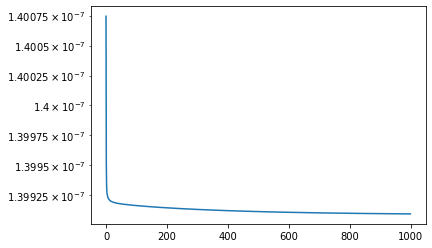

In [53]:
plt.plot(losses)
plt.yscale('log')

In [13]:
opt = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.1)
optimizer = L4(mlp.parameters(), opt, alpha=0.1, gamma=0.5)

In [14]:
def get_loss():
    return rmse_loss_fn_torch(mlp(x), y)

losses = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    loss = rmse_loss_fn_torch(mlp(x), y)
    loss.backward()
    optimizer.step(get_loss)
    if i % 100 == 0:
        losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

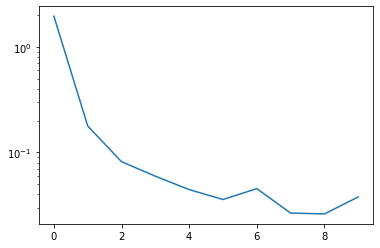

In [15]:
plt.plot(losses)
plt.yscale('log')

In [564]:
def loss(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    return np.concatenate(grads)

In [ ]:
sizes = []
losses = []

for n in tqdm([5, 10, 50, 100, 150, 200, 300, 400, 500, 1000]):
    x_line = y_line = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x_line, y_line)
    Z = np.exp(X + Y)
    x_2d = np.stack([X, Y], axis=2)
    x = torch.from_numpy(x_2d.reshape((n*n, 2))).to(device)
    y = torch.from_numpy(Z.reshape((n*n, 1))).to(device)
    sizes.append(len(y))
    
    x_line = y_line = np.linspace(-1, 1, 257)
    X, Y = np.meshgrid(x_line, y_line)
    Z = np.exp(X + Y)
    x_2d = np.stack([X, Y], axis=2)
    x_test = torch.from_numpy(x_2d.reshape((257*257, 2))).to(device)
    y_test = torch.from_numpy(Z.reshape((257*257, 1))).to(device)
    
    width = 20
    mlp = nn.Sequential(
        nn.Linear(2, width),
        nn.Tanh(),
        nn.Linear(width, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    ).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    N = len(param_vector)

    result = optimize.minimize(loss,
                               param_vector, 
                               args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x, y, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-18,
                                   'maxiter': 25000,
    #                                'finite_diff_rel_step': 1e-15
                               },
                            )

    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = result.x[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)

    losses.append(rmse_loss_fn_torch(mlp(x_test), y_test).item())
    

In [ ]:
plt.plot(sizes, losses)
plt.yscale('log')
plt.xscale('log')
plt.ylabel("RMSE loss")
plt.xlabel("Training dataset size")

### let's do some digging into why this 1e-7 floor seems to exist across varying dataset sizes and model sizes

In [ ]:
result.x

In [ ]:
rmse_loss_fn_torch(mlp(x), y).backward()

In [ ]:
mlp[0].weight.grad

In [ ]:
mlp[0].bias.grad

In [ ]:
mlp[2].weight.grad

In [ ]:
mlp[2].bias.grad

In [ ]:
mlp[4].weight.grad

In [ ]:
mlp[4].bias.grad

In [ ]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-7)

In [ ]:
sgd_losses = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    rmse_loss_fn_torch(mlp(x), y).backward()
    optimizer.step()
    if i % 1000 == 0:
        sgd_losses.append(rmse_loss_fn_torch(mlp(x_test), y_test).item())

In [ ]:
plt.plot(sgd_losses)
plt.yscale('log')

In [ ]:
l = 0
for i, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[i]]
    l += lenghts[i]
    param_data_shaped = param_data.reshape(shapes[i])
    param.data = torch.tensor(param_data_shaped).to(device)

In [ ]:
rmse_loss_fn_torch(mlp(x_test), y_test)

In [ ]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-8)

In [ ]:
sgd_losses = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    rmse_loss_fn_torch(mlp(x), y).backward()
    optimizer.step()
    if i % 1000 == 0:
        sgd_losses.append(rmse_loss_fn_torch(mlp(x_test), y_test).item())

In [ ]:
rmse_loss_fn_torch(mlp(x_test), y_test)

In [ ]:
optimizer.zero_grad()
rmse_loss_fn_torch(mlp(x), y).backward()
optimizer.step(lambda: rmse_loss_fn_torch(mlp(x), y))
rmse_loss_fn_torch(mlp(x_test), y_test)